<a href="https://colab.research.google.com/github/erenkaynarr/bitirmeprojesi/blob/main/bitirmeproje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gerekli kutuphanelerin kurulmasi ve calistirilmasi

In [ ]:
!pip install datasets==1.9.0 transformers tokenizers sentence-transformers umap-learn

In [ ]:
pip install sentence-transformers

In [ ]:
!pip install datasets

In [ ]:
!pip install umap-learn

In [ ]:
pip install datashader

In [6]:

import matplotlib.pyplot as plt
import colorcet
import matplotlib.colors
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import matplotlib.pyplot as plt
import colorcet
import matplotlib.colors
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
import holoviews.operation.datashader as hd
import numpy as np
import pandas as pd
import itertools
import random
from sentence_transformers import SentenceTransformer, InputExample, evaluation, losses
from torch.utils.data import DataLoader
from sklearn.metrics.pairwise import paired_cosine_distances, paired_euclidean_distances, paired_manhattan_distances
from datasets import list_datasets, load_dataset
import seaborn as sns
import umap
import umap.plot
import pprint
pd.options.display.max_colwidth = -1
pd.options.display.min_rows = 100

/usr/local/lib/python3.10/dist-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)
<ipython-input-6-6b70166eb27d>:30: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.options.display.max_colwidth = -1


Dataset yuklenmesi

In [7]:
train_ex = 200000
test_ex = 20000

In [8]:
data = load_dataset("PolyAI/banking77")
data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})

In [9]:
pd.DataFrame({'t':data['train']['text'], 'l':data['train']['label']})\
.groupby('l')\
.apply(lambda x: list(x['t'][:5])).reset_index()

,l,0
0,0,"[Please help me with my card. It won't activate., I tired but an unable to activate my card., I want to start using my card., How do I verify my new card?, I tried activating my plug-in and it didn't piece of work]"
1,1,"[I want to open an account for my children, How old do you need to be to use the banks services?, Whats the minimum age to have an account, Can my children open an account?, How old do I need to be?]"
2,2,"[Hi, I have an apple watch. How do I use it to top up my card?, Can I use google pay to top up?, why top up is not working even if I got my American Express in Apple Bay?, Can I deposit money using Apple Pay?, Can I use google pay for topping -up]"
3,3,"[I can use this card at which ATMs?, Can I use the card at any cash machine?, What locations can I get money from?, What ATMs take this card?, Which ATM's can I use to make a withdrawal?]"
4,4,"[Can I add money automatically to my account while traveling?, i need help finding the auto top up option., What are the maximum amount you can do for auto top-up?, I can't find the auto-top up option., Does the auto top-up have any limits?]"
5,5,"[help my money isnt showing up, how do i see what i transferred, Hello. Can you help figure out why the recent transfer from my UK bank account isn't showing up?, I've made a transfer from France two days ago but I was wondering if international transfers take longer to arrive because it hasn't made it yet., After I transferred money the balance remained the same.]"
6,6,"[Why is my last cheque deposit taking so long?, I am still waiting for a the cash I deposited this morning, I tried using a check to update my balance, but it isn't work? Is something wrong?, I deposited cash but it isn't showing up in my account, I put some cash into my account but it's not displaying that on my balance.]"
7,7,"[is there something blocking me from making transfers, What are the reasons for my beneficiary not being allowed?, Is there something wrong with the transferring functions? I keep trying to transfer funds and only get an error message., What are the reasons a beneficiary would be denied?, A transfer to my account was denied.]"
8,8,"[Cancel a transaction, Am I able to cancel a transfer I just made, I needed to make a payment on my account, but I typed in the incorrect number. The app won't allow me to cancel this transaction. I need it cancelled ASAP!!, I made a mistake this morning when I did a transfer. How do I reverse it?, Can I cancel a transaction?]"
9,9,"[Are there any express fees if i want my new card faster?, Do I need to do something to get a new card once it expires?, I am overseas in China, can I get a replacement card?, Can I get a new card with new expiration date in China?, Are there restrictions on new cards in China?]"


Ikili verilerin olusturulmasi

In [10]:
def create_pair_data(text, labels, size):
    data_dict = {}
    for x in  pd.DataFrame({"text":text,
                          "label":labels})\
            .groupby("label")\
            .apply(lambda x: list(x["text"]))\
            .reset_index().values.tolist() :
        data_dict[x[0]] = x[1]
    label1 = []
    for d in data_dict.keys():
        label1.extend(list(itertools.combinations(data_dict[d], 2)))
    #print(len(label1))

    label0 = []
    for d1 in data_dict.keys():
        for d2 in data_dict.keys():
            if d1 != d2:
                label0.extend(list(itertools.product(data_dict[d1], data_dict[d2])))
    #print(len(label0))
    label0 = random.sample(label0, len(label1))
    #print(len(label0))
    return random.sample(label1, int(size/2)), random.sample(label0, int(size/2))

In [11]:
train_label_1, train_label_0 = create_pair_data(data["train"]['text'],
                                                data["train"]['label'], train_ex)

In [12]:
test_label_1, test_label_0 = create_pair_data(data["test"]['text'],
                                              data["test"]['label'],
                                              test_ex)
print(len(test_label_1), len(test_label_0))
pprint.pprint(test_label_0[:2])
pprint.pprint(test_label_1[:2])

10000 10000
[('How can I tell what the limit is to top-ups?',
  'what is the process for setting up a pin'),
 ('Can I receive a new card while I am in China?',
  'Are there any sort of fees involved for top of transfers?')]
[('Can I change from one currency to another?', 'Where do I go to change GBP?'),
 ('If I was mugged and lost everything, how do I access my account and app?',
  'lost phone, can i still access account?')]


In [13]:
train_examples = [InputExample(texts=x, label=1.0) for x in train_label_1] + \
                 [InputExample(texts=x, label=0.0) for x in train_label_0]

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=8)

Modelin kurulumu

In [14]:
model_name = 'all-mpnet-base-v2'
model = SentenceTransformer(model_name)
#sonradan t5 ile degistirilebilir

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Model degerlendirme ve Gorsellestirme

Batches:   0%|          | 0/2500 [00:00<?, ?it/s]

Batches:   0%|          | 0/2500 [00:00<?, ?it/s]

0.593459
0.21188542


<ipython-input-15-ea2265baad2e>:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cosine_scores[:int(test_ex/2)], label = "1")
<ipython-input-15-ea2265baad2e>:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cosine_scores[int(test_ex/2):], label = "0")


<Axes: ylabel='Density'>

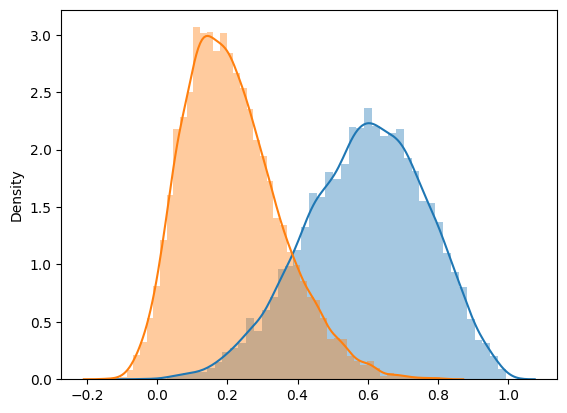

In [15]:
embeddings1 = model.encode([x[0] for x in test_label_1] + [x[0] for x in test_label_0],
                           batch_size= 8, show_progress_bar=True, convert_to_numpy=True)

embeddings2 = model.encode([x[1] for x in test_label_1] + [x[1] for x in test_label_0],
                           batch_size= 8, show_progress_bar=True, convert_to_numpy=True)

labels = [1]*len(test_label_1) + [0]*len(test_label_0)

cosine_scores = 1 - (paired_cosine_distances(embeddings1, embeddings2))

print(cosine_scores[:int(test_ex/2)].mean())
print(cosine_scores[int(test_ex/2):].mean())


sns.distplot(cosine_scores[:int(test_ex/2)], label = "1")
sns.distplot(cosine_scores[int(test_ex/2):], label = "0")

In [16]:
# kotu tahminler

tmp_df = pd.DataFrame({"s1":[x[0] for x in test_label_1] + [x[0] for x in test_label_0],
              "s2":[x[1] for x in test_label_1] + [x[1] for x in test_label_0],
              "lbl":[1]*len(test_label_1) + [0]*len(test_label_0),
              "cos": cosine_scores})\
.assign(delta = lambda x: np.abs(x.lbl - x.cos)).sort_values("delta", ascending=False)

# dogru ve yanlis tahminler
scores = []
for x in range(10,90,1):
    scores.append( ( x/100, tmp_df.assign(pred = lambda xx: xx.cos > x/100 )\
          .assign(correct = lambda xxx: xxx.pred == xxx.lbl).correct.mean() ) )

best_score = sorted(scores, key = lambda x: x[1], reverse = True)[0]
print("Best accuracy of {} using threshold {}".format(best_score[1], best_score[0]))

print("\nBad predictions - ")
tmp_df.head(50)

Best accuracy of 0.88235 using threshold 0.39

Bad predictions - 


,s1,s2,lbl,cos,delta
4934,Do you support the EU?,Where can I find your locations?,1,-0.038371,1.038371
3839,Can I get a card outside the UK?,Where do you support?,1,-0.012248,1.012248
5277,How do I make sure I don't run out of money on my card while traveling?,What is the highest limit for Auto Top?,1,0.028068,0.971932
987,What's the deal with no cryptocurrency on your app?,My transfer to beneficiary didn't go through,1,0.032434,0.967566
3426,what is required documents for new card process ?,For some reason my contactless won't work for me.,1,0.033134,0.966866
947,"There is an incoming payment into my account, but it is deactivated. Will they still be processed?",Which country's currency do you support?,1,0.037655,0.962345
431,what is required documents for new card process ?,How can I find out where my contactless works?,1,0.039853,0.960147
3840,"There is an incoming payment into my account, but it is deactivated. Will they still be processed?",Can someone assist me with the details explaining which fiat currencies that you support?,1,0.040379,0.959621
5794,i live in the US can i still get a card?,Where do you support?,1,0.042325,0.957675
1406,Is it possible to get a card if I'm not in the UK?,How many countries do you support?,1,0.053758,0.946242


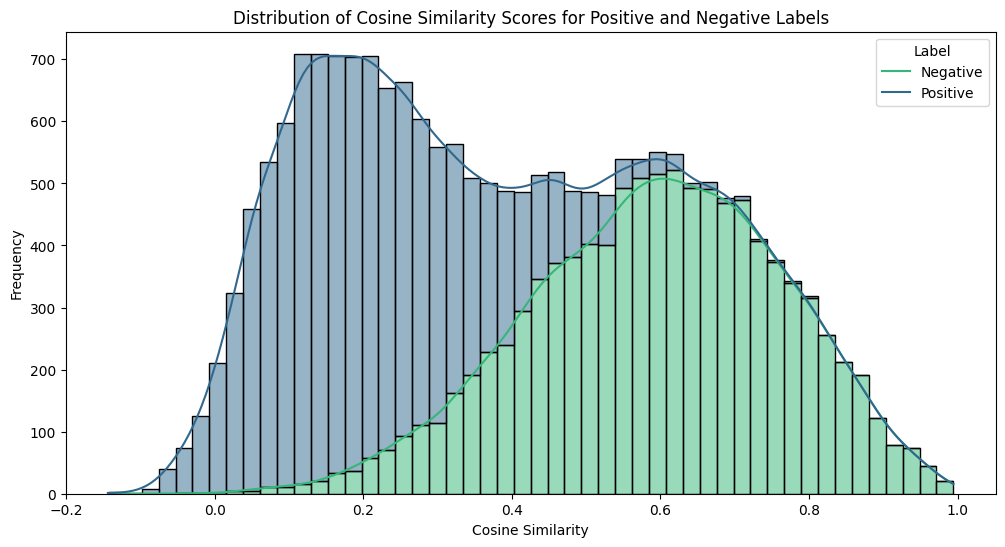

In [17]:
# Pozitif ve Negatif Etiketli Çiftlerin Benzerlik Skorları Histogramı
plt.figure(figsize=(12, 6))
sns.histplot(tmp_df, x='cos', hue='lbl', bins=50, kde=True, multiple='stack', palette='viridis')
plt.title('Distribution of Cosine Similarity Scores for Positive and Negative Labels')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend(title='Label', labels=['Negative', 'Positive'])
plt.show()

Batches:   0%|          | 0/385 [00:00<?, ?it/s]

<Axes: >

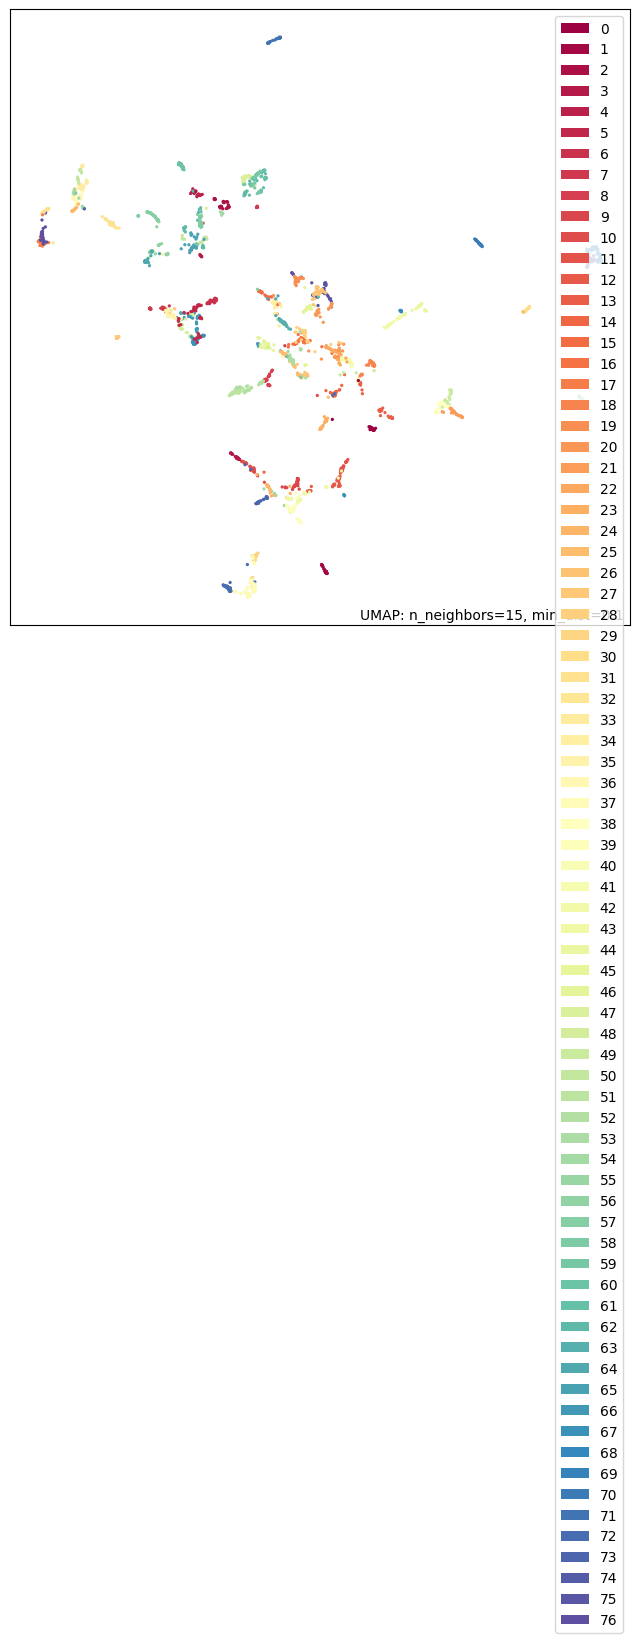

In [18]:
embeddings3 = model.encode(data["test"]["text"], batch_size= 8,
                           show_progress_bar=True, convert_to_numpy=True)

embedding_umap = umap.UMAP(n_components=2,).fit(embeddings3)

umap.plot.points(embedding_umap, labels=pd.Series(data["test"]["label"]))

In [19]:
train_loss = losses.CosineSimilarityLoss(model)

#Tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=1,
          warmup_steps= int(0.1*(train_ex/8)) )

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/25000 [00:00<?, ?it/s]

In [20]:
model.save(model_name+"_banking77")

Batches:   0%|          | 0/2500 [00:00<?, ?it/s]

Batches:   0%|          | 0/2500 [00:00<?, ?it/s]

0.92357063
0.009455476


<ipython-input-21-5cdf66459c03>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cosine_scores[:int(test_ex/2)], label = "1")
<ipython-input-21-5cdf66459c03>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(cosine_scores[int(test_ex/2):], label = "0")


<Axes: ylabel='Density'>

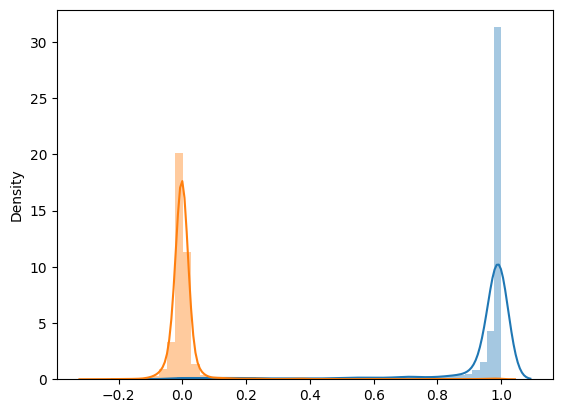

In [21]:
embeddings1 = model.encode([x[0] for x in test_label_1] + [x[0] for x in test_label_0], batch_size= 8, show_progress_bar=True, convert_to_numpy=True)
embeddings2 = model.encode([x[1] for x in test_label_1] + [x[1] for x in test_label_0], batch_size= 8, show_progress_bar=True, convert_to_numpy=True)
labels = [1]*len(test_label_1) + [0]*len(test_label_0)

cosine_scores = 1 - (paired_cosine_distances(embeddings1, embeddings2))

print(cosine_scores[:int(test_ex/2)].mean())
print(cosine_scores[int(test_ex/2):].mean())


sns.distplot(cosine_scores[:int(test_ex/2)], label = "1")
sns.distplot(cosine_scores[int(test_ex/2):], label = "0")

In [22]:
tmp_df = pd.DataFrame({"s1":[x[0] for x in test_label_1] + [x[0] for x in test_label_0],
              "s2":[x[1] for x in test_label_1] + [x[1] for x in test_label_0],
              "lbl":[1]*len(test_label_1) + [0]*len(test_label_0),
              "cos": cosine_scores})\
.assign(delta = lambda x: np.abs(x.lbl - x.cos)).sort_values("delta", ascending=False)

# getting correct incorrect match
scores = []
for x in range(10,90,1):
    scores.append( ( x/100, tmp_df.assign(pred = lambda xx: xx.cos > x/100 )\
          .assign(correct = lambda xxx: xxx.pred == xxx.lbl).correct.mean() ) )

best_score = sorted(scores, key = lambda x: x[1], reverse = True)[0]
print("Best accuracy of {} using threshold {}".format(best_score[1], best_score[0]))

print("\nBad predictions - ")
tmp_df.head(50)

Best accuracy of 0.9772 using threshold 0.11

Bad predictions - 


,s1,s2,lbl,cos,delta
91,someone stole my money,There's a direct debit I wish to dispute,1,-0.129690,1.129690
8623,Help me. There is a Direct Debit that I didn't make.,someone stole my money,1,-0.127418,1.127418
8177,someone stole my money,This Direct Debit payment may not be right.,1,-0.125854,1.125854
8630,someone stole my money,"I have a direct debit transaction I have not set up, but would like to .",1,-0.124999,1.124999
862,someone stole my money,I don't recognize a debit payment that was made and would like to find out about the payment.,1,-0.122105,1.122105
7048,someone stole my money,I didn't make this direct debit transaction,1,-0.113013,1.113013
6016,someone stole my money,Weird charges are appearing in my debit account.,1,-0.111428,1.111428
3393,What is this direct debit I am seeing?,Someone has taken my money and I don't know who,1,-0.077640,1.077640
5532,There is a Direct Debit that I don't recognize.,Someone has taken my money and I don't know who,1,-0.077562,1.077562
7481,This Direct Debit payment may not be right.,Someone has taken my money and I don't know who,1,-0.077466,1.077466


Batches:   0%|          | 0/385 [00:00<?, ?it/s]

<Axes: >

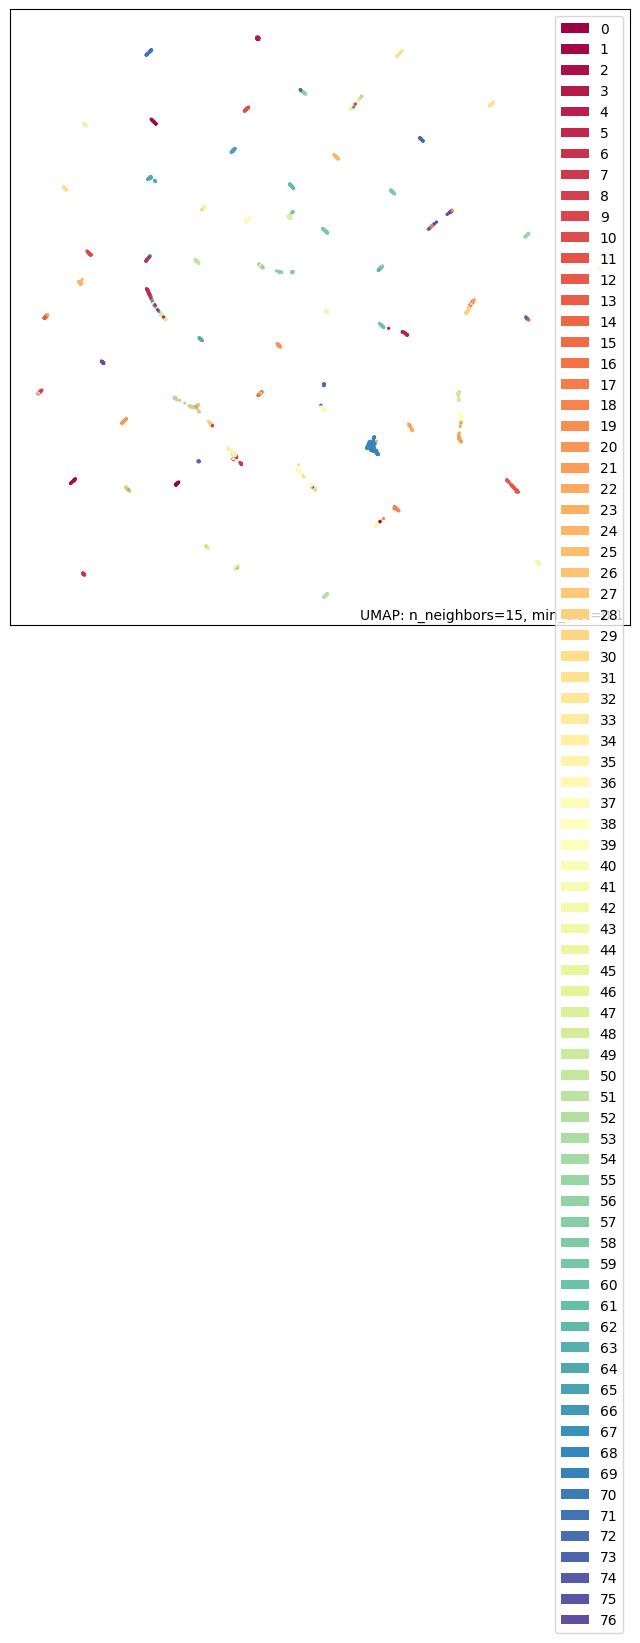

In [23]:
embeddings3 = model.encode(data["test"]["text"], batch_size= 8, show_progress_bar=True, convert_to_numpy=True)

embedding_umap = umap.UMAP(n_components=2,).fit(embeddings3)

umap.plot.points(embedding_umap, labels=pd.Series(data["test"]["label"]))

Cikti Alinmasi